# Find Bubble Nucleation Sites

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
from itertools import groupby, cycle
from scipy.ndimage import gaussian_filter1d

### Simulation Parameters 

In [2]:
nLat = 8192
nTime = 256
step = 1

lamb = 1.5; print('lamb = ', lamb)
phi0 = 2*np.pi/7.; print('phi0 = ', phi0)
nu = 2.*10**(-3)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 8 * 0.5 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi_initial = np.pi

nyq = nLat//2+1; spec = nyq//16; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 16.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)
nonTime = int(2./np.sqrt(m2eff)/dtout)
tcheck = int(1./np.sqrt(m2eff)/dtout); print('tcheck =', tcheck)

lamb =  1.5
phi0 =  0.8975979010256552
m2eff =  0.01
lenLat =  3162.2776601683795
dx, dk, spec  0.3860202221885229 0.0019869176531592202 256
dtout/dt =  32.0
light_cone =  2
tcheck = 12


In [3]:
lenLat*np.sqrt(4*nu)

282.842712474619

In [4]:
spec*dk/np.sqrt(4*nu)

5.686890160842709

In [5]:
spec * dk * 16

8.138414707340166

In [6]:
instanton_location = '/home/dpirvu/inst/instantons/dev/bubcorr_instanton_sim.dat'
suffix = '_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
pickle_location = '/home/dpirvu/pickle_location/new_new_bubble_correlations/phi0'+str(int(20*np.pi/phi0))+'_lambda'+str(int(10*lamb))+'/'

def sim_location(sim):
    return '/gpfs/dpirvu/bubble_correlations/t'+str(nTime)+'_x'+str(nLat)+'_len{:.4f}'.format(lenLat)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_alph{:.4f}'.format(alpha)+'_spec'+str(spec)+'_sim'+str(sim)+'_fields.dat'
def positive_data_file(minSim, maxSim, multiplier, filter):
    return pickle_location+'positive_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'
def negative_data_file(minSim, maxSim, multiplier, filter):
    return pickle_location+'negative_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'

threhsolds:  [4.658106296918165, 4.759673735059503, 4.861241173200842]


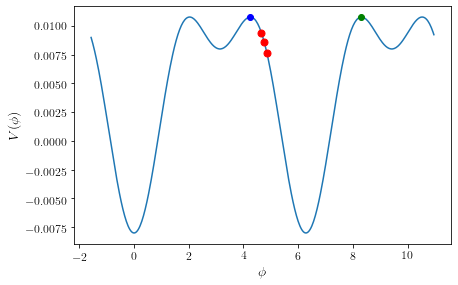

In [7]:
def V(phi, lamb=1.5):
    return ( -np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2 ) * 4 * nu
right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')
far_right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[2*np.pi, 3*np.pi], method='bounded')
phi_upper_bound = sco.fsolve(lambda x: V(x) - V(np.pi), 5.5)[0]

list_multiplier = [0.2, 0.25, 0.3]
list_threshold= [right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-2*phi_initial)*multiplier for multiplier in list_multiplier]; print('threhsolds: ', list_threshold)

fig, ax = plt.subplots(figsize=(7,4))
plt.plot([i for i in np.arange(-np.pi/2, 3.5*phi_initial, phi_initial/100)], [V(i) for i in np.arange(-np.pi/2, 3.5*phi_initial, phi_initial/100)])
[plt.plot(i, V(i), 'ro', ms = 7) for i in list_threshold]
plt.plot(right_phi_at_V_max.x, V(right_phi_at_V_max.x), 'bo')
plt.plot(far_right_phi_at_V_max.x, V(far_right_phi_at_V_max.x), 'go')
plt.xlabel(r'$\phi$'); plt.ylabel(r'$V(\phi)$'); plt.show()

In [8]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [9]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

def plot_slices(sim, i, j, t, filter):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    tabl = cycle((tableau1[::]))
    line = cycle(('solid', 'dashed', 'dashdot', 'dotted'))
    i0 = i
    for slice in all_data[sim][i:j:t]:
        slice = gaussian_filter1d(slice, sigma=filter, mode='wrap')
        plt.plot(np.sqrt(4*nu)*dx*np.arange(len(slice)), slice, label=r'$\tau = \,$'+str((i0-i)//t+1), color=next(tabl), linestyle=next(line))
        i0 = i0 + t
#    labelLines(plt.gca().get_lines(), xvals=(2*len(slice)/3, len(slice)), align=False)
    plt.grid(alpha=0.8, linestyle='dashed', linewidth=0.5)
    plt.legend(); plt.xlabel( r'$\phi_0^{-1} \sqrt{V_0} \; r$'); plt.ylabel(r'$\bar{\phi}$')
    ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 2))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    plt.savefig('/home/dpirvu/bubble_evolution.pdf')
    return

tableau1 = [(50, 162, 81), (172,217,141), (255,127,15), (255,185,119), (60,183,204), (152,217,228), (184,90,13), (255,217,74), (57,115,124), (134,180,169), (130,133,59), (204,201,77)]
for i in range(len(tableau1)):
    r, g, b = tableau1[i]    
    tableau1[i] = (r / 255., g / 255., b / 255.)

In [10]:
image1 = np.load('/home/dpirvu/pickle_location/thick_wall_average_bubble/average_bubble_from_sim0_up_to_sim99_for_phi01.5708_lambda1.5_len1581.1388_x4096.npy')[0][0]
image = np.load('/home/dpirvu/phi070_lambda15/av_thick_bubble_snapshot.npy')

fig, ax = plt.subplots(1, 2, figsize = (12,4), gridspec_kw={'width_ratios': [4, 5]})

image1 = image1[1600:2350]
ext = [0, np.sqrt(4*nu)*dx*image1.shape[1], 0, np.sqrt(4*nu)*dtout*image1.shape[0]]
#ext = [0, image1.shape[1], 0, image1.shape[0]]
im = ax[0].imshow(image1, aspect='auto', interpolation='none', origin='lower', cmap='viridis', extent=ext)

ax[0].axhline(np.sqrt(4*nu)*dtout*323, color='r', linestyle='--')
ax[0].axhline(np.sqrt(4*nu)*dtout*342, color='r', linestyle='--')

clb = plt.colorbar(im, ax = ax[0], pad=0.01); clb.set_label(r'$\bar{\phi}$')
multp = 3
clb.set_ticks(np.arange(10)*np.pi/multp, update_ticks=True)
clb.set_ticklabels([r'$\pi$' if (iii/multp)==1. else str(int(iii/multp))+r'$\pi$' if (iii/multp).is_integer() 
                    else r'$\frac{%s\pi}{%s}$'%(iii, multp) for iii in np.arange(10)], update_ticks=True)
ax[0].set(xlabel = r'$\phi_0^{-1} \sqrt{V_0} \; r$', ylabel = r'$\phi_0^{-1} \sqrt{V_0} \; t$')

saves = []
for temp in image1[325:340]:
    peaks = scs.find_peaks(temp)[0]
    fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)
    height, left_ips, right_ips, peaks = height[fwhm==max(fwhm)], left_ips[fwhm==max(fwhm)], right_ips[fwhm==max(fwhm)], peaks[fwhm==max(fwhm)]
    ax[1].plot(np.sqrt(4*nu)*dx*np.arange(len(temp)), temp, color='b', alpha=0.05, linewidth=2)
    saves.append([temp, max(fwhm)/2., height, left_ips, right_ips, peaks])

saves = np.asarray(saves)
temps, fwhms, heights, lefts, rights, peaks = saves[:,0], saves[:,1], saves[:,2], saves[:,3], saves[:,4], saves[:,5]
ax[1].plot(np.sqrt(4*nu)*dx*np.arange(len(np.mean(temps))), np.mean(temps), color='r', alpha=1)


pk = scs.find_peaks(np.mean(temps))[0]
w, h, l, r = scs.peak_widths(np.mean(temps), pk, rel_height=0.5)
h, l, r, pk = h[w==max(w)], l[w==max(w)], r[w==max(w)], pk[w==max(w)]
ax[1].hlines(h, np.sqrt(4*nu)*dx*l, np.sqrt(4*nu)*dx*r, color=tableau1[0], linewidth=3)
ax[1].plot(np.sqrt(4*nu)*dx*pk, np.mean(temps)[pk], marker="*", color=tableau1[2], ms=12)

#ax[1].hlines(np.mean(heights), np.sqrt(4*nu)*dx*np.mean(lefts), np.sqrt(4*nu)*dx*np.mean(rights), color=tableau1[0], linewidth=3)
#ax[1].plot(np.sqrt(4*nu)*dx*np.mean(peaks), np.mean(temps)[np.mean(peaks)], marker="*", color=tableau1[2], ms=12)

plt.grid(alpha=0.8, linestyle='dashed', linewidth=0.5)
ax[1].set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$'); ax[1].set_ylabel(r'$\bar{\phi}$')
ax[1].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 3))
ax[1].yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 3))
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
plt.savefig('/home/dpirvu/average_thick_bubble.pdf');
plt.show()

fwhms = fwhms[(np.mean(fwhms)-4*np.std(fwhms) < fwhms) & (fwhms < np.mean(fwhms)+4*np.std(fwhms))]
filter_size = np.mean(fwhms)/4.; print('filter size = ', filter_size)

smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)* np.exp(-0.5* (np.fft.fftfreq(len(slice), dx)*2*np.pi * dx * sigma)**2.)).real
MAXlist = [max(smoothen(temp, filter_size)) for temp in image1[325:340]]
print('Bubble height at nucleation for filter: ', np.mean(MAXlist), '\nDetection Thresholds: ',  list_threshold)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dpirvu/pickle_location/thick_wall_average_bubble/average_bubble_from_sim0_up_to_sim99_for_phi01.5708_lambda1.5_len1581.1388_x4096.npy'

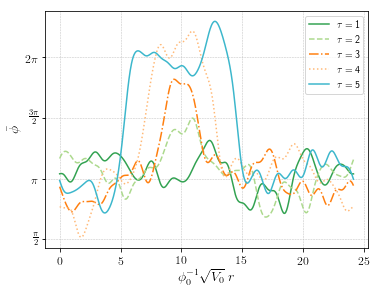

In [8]:
sim = 3
all_data = [np.reshape(np.genfromtxt(sim_location(sim)), (nTime, nLat))]
all_data = [[slice[4100:4800] for slice in simulation] for simulation in all_data]
#all_data = [[2*np.pi-slice for slice in simulation] for simulation in all_data]
plot_slices(0, 75, 191, 25, filter_size)

In [9]:
def weave(list1,list2):
    lijst = []
    i = 0
    while i < len(list1):
        lijst.append(list1[i])
        lijst.append(list2[i]) 
        i += 1
    return lijst

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

def identify_bubble_sites(simulation, bubble_thr):
    nvals, new_vals = 0, 0
    vals, times = [], []
    for t in range(nTime - int(tcheck//3)):
        # find new peaks in field and check if they are good bubble candidates
        peaks_new = find_peak_positions(simulation[t], bubble_thr)
        if peaks_new is not None:
            for pk in peaks_new:
                target_bounds = []
                for v in range(len(vals)):
                    # ensure new peaks are not in the light cone of the previously identified bubble nucleation sites
                    target_bounds += [i%nLat for i in range(vals[v] - np.abs(t - times[v])*light_cone, vals[v] + np.abs(t - times[v])*light_cone + 1)]
                if pk not in target_bounds:
                    vals.append(pk)
                    times.append(t)

                # discard element if future lightcone is not in tv
                if len(vals) > nvals:
                    for temp in range(times[-1], min(times[-1]+tcheck, nTime)):
                        boolShoot = False
                        deltat = temp-1 - times[-1]
                        for xemp in range(vals[-1] - deltat*light_cone, vals[-1] + deltat*light_cone + 1):
                            if not (bubble_thr < simulation[temp][xemp%nLat] < far_right_phi_at_V_max.x):#3*phi_initial):
                                vals = np.delete(np.asarray(vals), -1).tolist()
                                times = np.delete(np.asarray(times), -1).tolist()
                                boolShoot = True
                                break
                        if boolShoot:
                            break
                
#                if len(vals) > nvals:
#                    if any(simulation[pastt][vals[-1]] < 0 for pastt in range(times[-1])):
#                        vals = np.delete(np.asarray(vals), -1).tolist()
#                        times = np.delete(np.asarray(times), -1).tolist()

                if len(vals) > nvals: #crucial check here
                    bubbles = find_bubbles_at_t(simulation[t], bubble_thr)
                    nBubbles = len(bubbles)
                    bub_list, rmvlist = [], []
                    for v in range(nvals):
                        for index in range(nBubbles):
                             if (vals[v] in bubbles[index]):
                                bub_list.append(index)
                    bubbles_dup = [bubbles[index] for index in range(nBubbles) if index in set(bub_list)]
                    if bubbles_dup != []:
                        for bounds in bubbles_dup:
                            for c in range(nvals, len(vals)):
                                if (vals[c] in bounds):
                                    rmvlist.append(c)
                    if len(rmvlist) > 0:
                        vals = np.delete(np.asarray(vals), rmvlist).tolist()
                        times = np.delete(np.asarray(times), rmvlist).tolist()

                nvals = len(vals)
    newlist = []
    for v in range(len(times)):
        if times[v] < nonTime:
            newlist.append(v)
    vals = np.delete(np.asarray(vals), newlist).tolist()
    times = np.delete(np.asarray(times), newlist).tolist()
    return [[times[i], vals[i]] for i in range(len(vals))]

def find_bubbles_at_t(field_slice, bubble_thr):
    bubbles, mids = [], []
    vals = [x if field_slice[x] > right_phi_at_V_max.x else 0 for x in range(len(field_slice))]
    first_zero = next((i for i, x in enumerate(vals) if x == 0.), 0)
    vals = np.roll(vals, -first_zero)
    bubbles = [list(g) for k, g in groupby(vals, lambda x: x != 0) if k]
    for bubble in bubbles:
        if bubble[0] <= bubble[-1]:
            aa = np.arange(bubble[0], bubble[-1]+1)
        elif bubble[0] > bubble[-1]:
            bubble[0] = bubble[0]-nLat
            aa = np.arange(bubble[0], bubble[-1]+1)%nLat
        mids.append(aa)
    return mids

def all_bubble_sites(data, bubble_thr):
    return [identify_bubble_sites(simulation, bubble_thr) for simulation in data]

In [10]:
if False:
    some_data = np.asarray([np.reshape(np.genfromtxt(sim_location(sim)), (nTime, nLat)) for sim in range(1)])

    Filter1 = np.exp(-0.5* (np.fft.fftfreq(nLat, dx)*2*np.pi * dx * filter_size)**2.)
    Filter2 = np.fft.fft(np.exp(-0.5*(np.asarray([j if j < nLat/2+1 else nLat-j for j in range(nLat)])/(filter_size))**2.) / np.sqrt(2*np.pi) / (filter_size))

    smsim1 = [np.fft.ifft(np.fft.fft(slice) * Filter1).real for slice in some_data]
    smsim2 = [np.fft.ifft(np.fft.fft(slice) * Filter2).real for slice in some_data]
    smsim3 = [gaussian_filter1d(slice, sigma=filter_size, mode='wrap') for slice in some_data]

    for smsim in [smsim1, smsim2, smsim3]:
        colors = cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'))
        fig, ax = plt.subplots(1, 1, figsize = (16, 4))
        for multiplier, threshold, kkk in zip(list_multiplier, list_threshold, np.arange(len(list_multiplier))):
            col = next(colors)
            targets = identify_bubble_sites(smsim[0], threshold)
            print('for multiplier = ', multiplier, 'there are', len(targets), col, 'bubbles at (t, x):', targets)
            for tg in targets:
                ax.plot(np.sqrt(4*nu)*dx*tg[1], np.sqrt(4*nu)*dtout*tg[0], color=col, linestyle="None", marker = '+', ms=10)
            im = ax.imshow(smsim[0], aspect='auto', interpolation='none', origin='lower', extent=[0, np.sqrt(4*nu)*nLat*dx, 0, np.sqrt(4*nu)*nTime*dtout])
        clb = plt.colorbar(im, ax = ax, pad=0.01)
        clb.set_label(r'$\phi$')
        ax.set(xlabel = r'$\phi_0^{-1} \sqrt{V_0} x$', ylabel = r'$\phi_0^{-1} \sqrt{V_0} t$')
        plt.tight_layout()
        plt.show()

For sims  0  to  1
8
8
8
3
3
3
for multiplier =  0.2 there are 8 (1.0, 0.8509803921568627, 0.2901960784313726) bubbles at (t, x): [[38, 6409], [39, 2254], [54, 2789], [82, 1986], [97, 1612], [124, 2546], [128, 2985], [153, 1016]]
for multiplier =  0.25 there are 8 blue bubbles at (t, x): [[40, 2253], [40, 6412], [55, 2787], [82, 1986], [99, 1613], [125, 2546], [130, 2984], [155, 1016]]
for multiplier =  0.3 there are 8 (1.0, 0.4980392156862745, 0.058823529411764705) bubbles at (t, x): [[41, 2253], [41, 6415], [60, 2784], [83, 1985], [106, 1623], [125, 2546], [161, 1018], [245, 3159]]


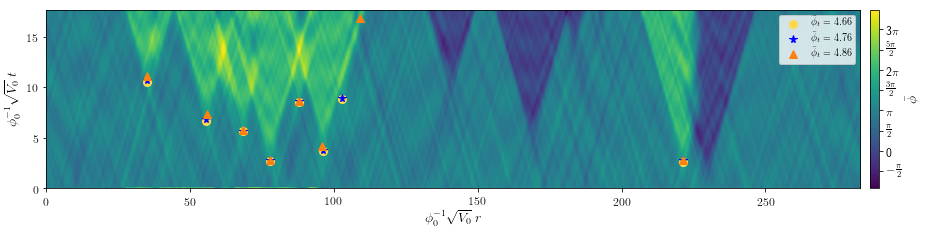

Done.


In [14]:
for minSim, maxSim in zip(splitdata, splitdata[1:]):
#    all_data = np.asarray([np.reshape(np.genfromtxt(sim_location(sim)), (nTime, nLat)) for sim in range(minSim, maxSim)])
    all_data = np.asarray([np.reshape(np.genfromtxt(sim_location(sim)), (nTime, nLat)) for sim in range(48, 49)])
    all_data = np.asarray([np.roll(slice, nLat//3) for slice in all_data])
    data_pos = np.asarray([[smoothen(slice, filter_size) for slice in simulation] for simulation in all_data])
    data_neg = np.asarray([[2*phi_initial - np.asarray(j) for j in i] for i in data_pos])
    print('For sims ', minSim, ' to ', maxSim)

    targets_pos = [all_bubble_sites(data_pos, threshold) for threshold in list_threshold]
    targets_neg = [all_bubble_sites(data_neg, threshold) for threshold in list_threshold]

    for sim in range(len(targets_pos[0])):
        for i in reversed(range(len(targets_pos[0][sim]))):
            if targets_pos[0][sim][i] in targets_pos[1][sim] and targets_pos[0][sim][i] in targets_pos[2][sim]:
                del targets_pos[1][sim][targets_pos[1][sim].index(targets_pos[0][sim][i])]
                del targets_pos[2][sim][targets_pos[2][sim].index(targets_pos[0][sim][i])]
                del targets_pos[0][sim][i]
                break

    for sim in range(len(targets_neg[0])):
        for i in reversed(range(len(targets_neg[0][sim]))):
            if targets_neg[0][sim][i] in targets_neg[1][sim] and targets_neg[0][sim][i] in targets_neg[2][sim]:
                del targets_neg[1][sim][targets_neg[1][sim].index(targets_neg[0][sim][i])]
                del targets_neg[2][sim][targets_neg[2][sim].index(targets_neg[0][sim][i])]
                del targets_neg[0][sim][i]
                break

    [print(len([item for sublist in targets_pos[mm] for item in sublist])) for mm in range(len(list_multiplier))]
    [print(len([item for sublist in targets_neg[mm] for item in sublist])) for mm in range(len(list_multiplier))]

    for sim in range(len(data_pos)):
        fig, ax = plt.subplots(1, 1, figsize = (18, 3))
        colors = cycle((tableau1[7], 'blue', tableau1[2]))#cycle(('orange', 'lightgreen', 'r'))
        marks = cycle(('o', '*', '^'))
        for multiplier, threshold,kkk in zip(list_multiplier, list_threshold, np.arange(len(list_multiplier))):
            col = next(colors)
            mss = next(marks)
            targets = targets_pos[kkk][sim]
            print('for multiplier = ', multiplier, 'there are', len(targets), col, 'bubbles at (t, x):', targets)
            for www, tg in enumerate(targets):
                if www == 0:
                    ax.plot(np.sqrt(4*nu)*dx*tg[1], np.sqrt(4*nu)*dtout*tg[0], color=col, linestyle="None", marker = mss, ms=8, label=r'$\bar{\phi}_t'+' = {:.2f}$'.format(threshold))
                else:
                    ax.plot(np.sqrt(4*nu)*dx*tg[1], np.sqrt(4*nu)*dtout*tg[0], color=col, linestyle="None", marker = mss, ms=8)

            im = ax.imshow(data_pos[sim], aspect='auto', interpolation='none', origin='lower', zorder=-20, extent=[0, np.sqrt(4*nu)*nLat*dx, 0, np.sqrt(4*nu)*nTime*dtout])
        clb = plt.colorbar(im, ax = ax, pad=0.01)
        clb.set_label(r'$\bar{\phi}$')
        multp = 2
        clb.set_ticks(np.arange(-10, 20)*np.pi/multp, update_ticks=True)
        clb.set_ticklabels(['0' if iii == 0 else r'$\pi$' if (iii/multp)==1. else r'$-\pi$' if (iii/multp)==-1. 
                            else str(int(iii/multp))+r'$\pi$' if (iii/multp).is_integer()>0 
                            else str(-int(np.abs(iii)/multp))+r'$\pi$' if (iii/multp).is_integer()<0 
                            else r'$\frac{\pi}{%s}$'%(multp) if iii==1. else r'$-\frac{\pi}{%s}$'%(multp) 
                            if iii==-1. else r'$\frac{%s\pi}{%s}$'%(iii, multp) if iii>1 
                            else r'$-\frac{%s\pi}{%s}$'%(np.abs(iii), multp) for iii in np.arange(-10, 20)], update_ticks=True)
        ax.set(xlabel = r'$\phi_0^{-1} \sqrt{V_0} \; r$', ylabel = r'$\phi_0^{-1} \sqrt{V_0} \; t$')
        ax.set_rasterization_zorder(-10)
        plt.legend()
        plt.savefig('/home/dpirvu/egsim.pdf')
        plt.show()

#    for jj in range(len(list_multiplier)):
#        np.save(positive_data_file(minSim, maxSim, list_multiplier[jj], filter_size), targets_pos[jj])
#        np.save(negative_data_file(minSim, maxSim, list_multiplier[jj], filter_size), targets_neg[jj])
    print('Done.')